# Workshop: Utilising real-world data

In this workshop we will build upon the work done in the previous session with more practical tasks involing real-world data collected by researchers at the University of Bristol. This session, while still remaining simple and linear, will introduce you to some of the problems of dealing with real-world data and how researchers must come up with creative solutions in order to correctly utilise the data.

This tutorial should take up to 2 hours to complete.

Please read through each section carefully and complete each code block in order. Code that you're required to complete will be discussed in the text and marked with the following comment with the code blocks:

`#TODO: ...`

## 0. Recap

Last session we walked through a paper and looked to implement written theory into a practical implementation within Python. 

## 1. Python Introduction

As with the previous workshop, a basic understanding of programming concepts is assumed for this workshop. For a general refresher on Python and its syntax, follow this link: 
https://www.w3schools.com/python/

Within this tutorial we will be using the following basic concepts:

1. Dictionaries
2. Classes
3. Functions / Methods
4. numpy

## 2. Neuron Implementation

Below is an implementation of the simple LIF neuron from the last workshop. The data and functionality has been encapsulated within a class. Don't worry too much about how this is done, all that matters is that by writing our implementation in this manner, we are able to easily reuse and copy this neuron. 

In [1]:
class LIFNeuron():
    def __init__(self, **kwargs):
        self.v_thresh = kwargs.get("v_thresh", -50e-3)
        self.v_reset = kwargs.get("v_reset", -70e-3)
        self.tau = kwargs.get("tau", 20e-3)
        self.E_leak = kwargs.get("E_leak", -60e-3) 
        self.r = kwargs.get("r", 100e6)
        self.v = self.v_reset
        
    def run_spk(self, dt, i):
        # Calculate membrane potential and leakage
        self.v = self.v + (dt / self.tau * (self.E_leak - self.v + (self.r*i)))
        
        # Check if the membrane potential has exceeded the threshold
        if self.v > self.v_thresh:
            self.v = self.v_reset
            return 1
        else:
            return 0

Let's test this new implementation in the same basic simulation as we did in our previous workshop and plot the results. This simulation will loop for 50 timesteps and apply a constant current to the LIF neuron.

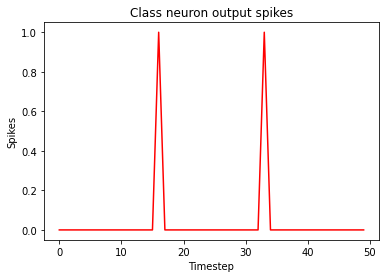

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Simulation parameters
timesteps = 50   # We simulate over 50 timesteps (50ms)
i = 25e-11       # Constant current of 250nA
dt = 1e-3        # Each timestep is 1ms
s_list = []      # This list will contain our simulation outputs

# Neuron parameters
neuron_params = {
    "v_thresh": -50e-3,
    "v_reset": -70e-3,
    "tau": 20e-3,
    "E_leak": -60e-3,
    "r": 100e6
}

# Create an instance of our neuron class using our defined neuron parameters
LIF = LIFNeuron(**neuron_params)

# This loop will run our simulation for the number of timesteps specified above
for time in range(timesteps):

    # Run our neuron spike function. It will return 1 or 0 to show if a spike has or has not occured
    s = LIF.run_spk(dt, i) 

    # Track the output spikes using a list
    s_list.append(s)

plt.plot(np.arange(len(s_list)), s_list, color="red")
plt.xlabel("Timestep")
plt.ylabel("Spikes")
plt.title("Class neuron output spikes")
plt.show()

As we can see from the above plot, the operation of this neuron is identical to the results of our previous simulation. Now that we have verified the operation of a single LIF neuron, lets expand this simulation by simulating multiple neurons at once.

In this example, our second LIF neuron will recieve a sinusoidal input current so that we can see a difference in our output plot.

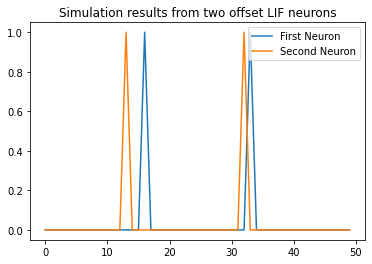

In [3]:
# Simulation parameters
timesteps = 50   # We simulate over 50 timesteps (50ms)
i_mean = 25e-11       # Constant current of 250nA
dt = 1e-3        # Each timestep is 1ms
s1_list = []     # This list will contain our simulation outputs from our first LIF neuron
s2_list = []     # This list will contain our simulation outputs from our second LIF neuron
    
# Neuron parameters contained in a dictionary
neuron_params = {
    "v_thresh": -50e-3,
    "v_reset": -70e-3,
    "tau": 20e-3,
    "E_leak": -60e-3,
    "r": 100e6
}
    
# Create an instance of our neuron class using our defined neuron parameters
first_LIF = LIFNeuron(**neuron_params)
second_LIF = LIFNeuron(**neuron_params)

# This loop will run our simulation for the number of timesteps specified above
for time in range(timesteps):
    
    # Find the time at this timestep
    t = time * dt
    
    # Calculate the discrete sinusoidal current at this timestep 
    i_sin = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))
    
    # Run our neuron spike function. It will return 1 or 0 to show if a spike has or has not occured
    s1 = first_LIF.run_spk(dt, i_mean) 
    s2 = second_LIF.run_spk(dt, i_sin)
    
    # Track the output spikes using a list
    s1_list.append(s1)
    s2_list.append(s2)
    
# Plotting the output spikes of both neurons
plt.plot(np.arange(len(s1_list)), s1_list, label="First Neuron")
plt.plot(np.arange(len(s2_list)), s2_list, label="Second Neuron")
plt.title("Simulation results from two offset LIF neurons")
plt.legend(loc=1)
plt.show()

As shown in the plot above, by encapsulating our data within a class, we are able to create two completely independent neurons that are both using the same code. Now we can start connecting these neurons together to form a basic neural network.

## 3. Simple Spiking Neural Networks (SNNs)

The further our understanding of SNNs let's briefly discuss an abstracted network. Below is a diagram showing a network of interconnected nodes.


#### IMAGE OF TWO LAYER SNN


Each of these nodes is attached to each other node in the subsequent layer. Each of the nodes present in this diagram can be seen as an LIF neuron like the one we implemented above. Information passed forward by each node is therefore presented as an input to the following nodes via this simple formula: 

$input_{n} = \sum\limits_{n=1}^N w_{n}x_{n}$

Where $n$ is the selected neuron, $N$ is the total number of neurons in the prior layer, $w$ is the weight of the connection and $x$ is the output from the prior neuron.

From this simple equation we can see that the input to our LIF neurons are now dependent on the output of previous neurons along a chain of weighted connections. When a neuron spikes within this network, it elicits a synaptic current for a single timestep. This current is similar to the constant current example we have used previously. This current is modified by the weight of the connection between the spiking neuron and the reciving neuron. When training networks, we seek to increases the strength of connections between two related neurons, while reducing the strength of connections between unrelated neurons. This may seem very confusing but don't worry too much about how to train these networks at the moment, as during this workshop we will be making changes to our weights by hand.



In order to begin building these networks we must first initialise a vector of LIF neurons to represent our input layer.

**NOTE**: The steps taken to build these networks within this section as NOT the most efficient way to build SNNs in Python, but require minimal external libraries and additional abstractions.

In [4]:
# Network parameters
input_size = 10

# Initialise an empty vector with the correct input layer size
input_layer = np.empty(input_size, dtype=object)

# Instatiate an LIF neuron for each element in the input vector
for element in range(input_size):
    input_layer[element] = LIFNeuron(**neuron_params)

Now that we have initialised our networks input layer, lets apply current to each neuron. In the block below we will apply a sinusoidal input to each neuron. Each neuron however should recieve its input a step out of phase with the previous neuron such that:

${t_{s}} = {\Delta t s}$

${i_{t}} = I_{mean}\left(1+\sin\left(\frac{2 \pi}{0.01}\,t_{s}\right)\right)$

$i_{n} = i_{t_{n}}$

where $s$ is the current timestep, $t$ is a vector containing all the timings in the simulation, $n$ is a given neuron in the vector, $i_{t}$ is the discrete value of a sinusoidal input at time $t_{s}$, $i_{n}$ is the input to a given neuron at time

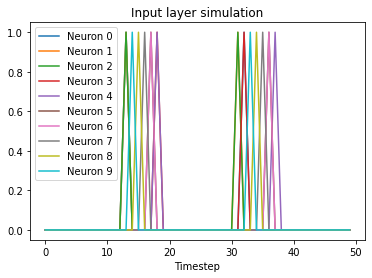

In [5]:
# Simulation parameters
timesteps = 50   # We simulate over 50 timesteps (50ms)
i_mean = 25e-11       # Constant current of 250nA
dt = 1e-3        # Each timestep is 1ms

# TODO: Create an output array that contains the output of each neuron at each timestep
outputs = np.zeros((input_size, timesteps))  # REMOVE

# TODO: Create a vector that contains the time at each timestep
t = np.arange(0, (timesteps*dt) + (input_size*dt), dt)

# Using this t array we can calculate each step of the input current sin wave
i_sin = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))

# This loop will run our simulation for the number of timesteps specified above
for time in range(timesteps):
    # To get an output from each of our neurons, we must also iterate over our input layer every timestep
    for n in range(input_size):
        # Collect the results from each neuron at each timestep
        outputs[n][time] = input_layer[n].run_spk(dt, i_sin[time+n])
#         input_layer[n].run_spk(dt, i_sin[time+n])
#         outputs[n][time] = input_layer[n].v

# Plot the output from each neuron
for idx, output in enumerate(outputs):
    plt.plot(np.arange(timesteps), output, label=f"Neuron {idx}")
    
plt.title("Input layer simulation")
plt.xlabel("Timestep")
plt.legend()
plt.show()

We have just successfully simulated the first layer of a SNN that we've built from scratch! Next, initialise a second layer to add to our simulation. Use the code above as a reference.

In [7]:
# TODO: Initialise a vector of LIF neuron objects. Refer to the code above for creating a vector of LIF objects
l1_size = 10 # Size of layer 1

# l1 = ?
l1 = np.empty(l1_size, dtype=object)

# Instatiate an LIF neuron for each element in the input vector
for element in range(l1_size):
    l1[element] = LIFNeuron(**neuron_params)

The two layers we've created this far will be densely connected together. This simply means that each neuron in each layer is connected to each neuron in the next layer. Now that we have two layers initialised we will create an array of weights that govern the strength of all the connections that must be made. To do this we shall create a 2d array of random values between 0 and 1. The size of this weight array should be $input\_size * l1\_size$ due to the dense connections. 

For the code section below, use the np.rand.random() function to create our weights array. Documentation found here:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html

In [8]:
# TODO: Create a 2d array of random weights 
# w1 = ?
w1 = np.random.rand(input_size, l1_size)

# Print out the weights matrix to confirm that the values are between 0 and 1
print(w1)

[[0.81989546 0.46847634 0.01509464 0.9920407  0.73068653 0.8876622
  0.02556545 0.56649636 0.23052489 0.98038286]
 [0.62978798 0.84577055 0.04165147 0.80321479 0.67982493 0.99912313
  0.5147016  0.81017397 0.05033149 0.33804108]
 [0.03441658 0.89159653 0.20085725 0.63588603 0.39566966 0.88080162
  0.30131272 0.17769937 0.63888351 0.20181383]
 [0.94813883 0.52627325 0.08631802 0.33731133 0.52051116 0.84536932
  0.90907343 0.56538263 0.88194037 0.95206885]
 [0.56317863 0.93940526 0.60775768 0.40230554 0.36178827 0.13302032
  0.66887273 0.36027732 0.94977116 0.3159512 ]
 [0.34625303 0.41306447 0.71476754 0.15566235 0.38812792 0.38663429
  0.59641212 0.43680895 0.17658024 0.17212912]
 [0.33420195 0.43968801 0.05580583 0.26470053 0.13237324 0.12029727
  0.22332817 0.00822282 0.35769134 0.80732279]
 [0.06868791 0.76384161 0.98823527 0.96094103 0.19002089 0.12974137
  0.73483809 0.40867826 0.66306255 0.12392308]
 [0.78820485 0.77845735 0.35936274 0.29235069 0.43291645 0.75185493
  0.43585783 

We now have the three components needed for our simple, two layer network. We have initialised both layers and the matrix of weights that governs their connections.

We're now ready to simulate our simple network. Below you should write the code to run a simulation with the following parameters:

timesteps: 150
dt: 1e-3
i: 25e-11

Below I've provided a function for you to use. This function will calculate the current provided to a neuron given the spike current, weight matrix and the input spike vector it's set to recieve. Use this within your simulation. 

**NOTE**: This can be a challenging task if you're not very familiar with Python. Don't hesitate to ask the instructors for guidance if you're struggling to complete the task.

In [ ]:
def calculate_current(spike_current, in_vector, out_size, weights):
    
    # 4. Output multiplied with spike current gives current output from each of the prior neurons
    currents = input_vector * spike_current
    
    # 5. Multiple currents with weighted connections
    currents = np.repeat(currents, out_size, axis=0).reshape((in_vector.shape[-1], out_size))
    l1_input = currents * weights
    
    
    
    return i

In [24]:
# 1. Take input to input layer
# 2. Apply spike function
# 3. Create array of spike outputs
# 4. Multiply spikes with spike current
# 5. Multiply spike current with weights
# 6. Apply this current the second layer
# 7. Apply spike function

# Simulation params
timesteps = 150
dt = 1e-3
i = 25e-11

# Input spike array
input_spikes = np.ones((input_size,timesteps))

# Arrays containing outputs from each 
input_out = np.empty((input_size,timesteps))
l1_out = np.empty((l1_size,timesteps))

for time in range(timesteps):
    # Create array containing output vector from each layer. NOTE: The layers are of the same size here
    out = np.empty(input_size)
    
    # Take the column from this timestep of input spikes
    inp = input_spikes[:,time]
    # Calculate total input current based on input array
    input_currents = calculate_current(i, inp)
    
    # 1 & 2. Take input and apply spike function 
    for neuron in range(input_size):
        
        s = input_layer[neuron].run_spk(dt, input_currents[neuron])
        out[neuron] = s
        
        # Record output of input layer for plotting
        input_out[neuron][time] = s
    
    # Calculate input currents to next layer
    l1_currents = calculate_current(i, out)
        
    # 6 & 7. Apply current and spike function to next layer
    for neuron in range(l1_size):
        # Current input to neuron is the sum of all the currents along its input vector
        inp = np.sum(l1_input, axis=neuron)
        s = l1[neuron].run_spk(dt, inp)
        
        # Record output from final layer
        l1_out[neuron][time] = s

Out spikes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Currents: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L1 inputs: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Out spikes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Currents: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L1 inputs: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Out spikes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Currents: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L1 inputs: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 

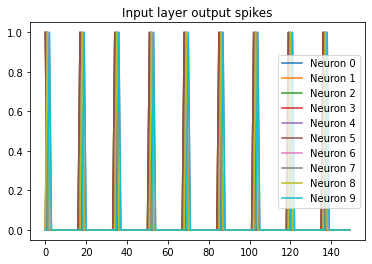

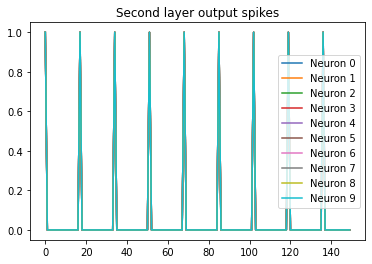

In [23]:
# Plot the output from each neuron
for idx, output in enumerate(input_out):
    plt.plot(np.arange(timesteps), output, label=f"Neuron {idx}")
    
plt.legend()
plt.title("Input layer output spikes")
plt.show()

# Plot the output from each neuron
for idx, output in enumerate(l1_out):
    plt.plot(np.arange(timesteps), output, label=f"Neuron {idx}")
    
plt.legend()
plt.title("Second layer output spikes")
plt.show()

Now change your weight array such that only the neuron in `input_layer[0]` spikes during this simulation.